# ALPR: Automatic License Plate Recognition

From the police department to the parking lot, license plate recognition is a technology that has been used for years. It is a computer vision task that involves detecting and recognizing license plates from images or video streams. The goal of this project is to build an ALPR system using OpenCV and Tesseract OCR.

<center><img src="images/jupyter/speed_camera.jpg" width="400"/></center>
<center><a href="https://parkers-images.bauersecure.com/wp-images/176822/gatso_speed_camera.jpg">Speed Camera</a></center>

## Introduction
This repository showcases few implementations of ALPR, from using OpenCV to using deep learning models. The goal is to provide a comprehensive understanding of how ALPR works and how it can be implemented in different ways.

We split the project into two main parts:
1. **License Plate Detection**: This part focuses on detecting the license plate in an image or video stream.
2. **OCR (Optical Character Recognition)**: This part focuses on recognizing the characters on the detected license plate.

In [16]:
# Imports

from ultralytics import YOLO
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt
import numpy as np
import cv2
import Filtering.visual as visual
import imutils

import OCR.CRNN.crnn as crnn
import OCR.CRNN.train as train
import OCR.CRNN.utils as utils
import torch
import glob
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## License Plate Detection

License plate detection will be our first step in the pipeline. While there are methods that integrate detection directly with subsequent tasks (such as end-to-end models), for simplicity we have chosen to address each component separately.

### Detection Methods

#### 1. Traditional Methods
Traditional methods rely on classical image processing techniques and are generally computationally efficient, making them suitable for environments with limited resources.

- Filters and Thresholding
  - Utilize edge detectors (e.g., Canny, Sobel) to identify boundaries in the image.
  - Apply thresholding to distinguish the license plate from the background based on intensity differences.
  
- HOG + SVM
  - Extract features using Histogram of Oriented Gradients (HOG) to capture the shape and structure of license plates.
  - Employ Support Vector Machines (SVM) to classify image regions and identify those that likely contain a license plate.


### 1.1 Filters and Thresholding

Usage of Filters and Thresholding in order to get boundaries

#### 1.1.1 Code

First, lets import the required libraries and load the image.

In [3]:
def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

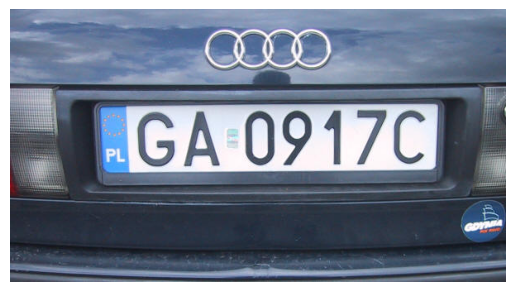

In [22]:
image = cv2.imread("images/car.jpg")

show_image(image)

Now, we will convert the image to grayscale, and then perform a **blackhat morphological operation** to highlight the text on the license plate. 

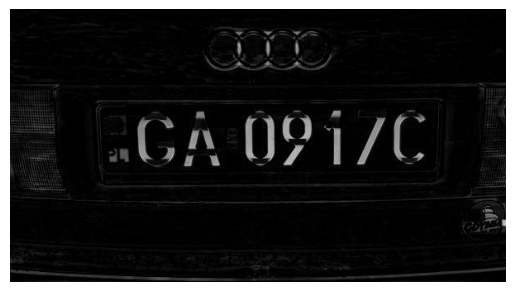

In [5]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))

blackhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)

show_image(blackhat)

Now, we will create a **closing morphological operation** using a square kernel to isolate the bright regions (like license plate characters) - using Otsu's thresholding to binarize the image.

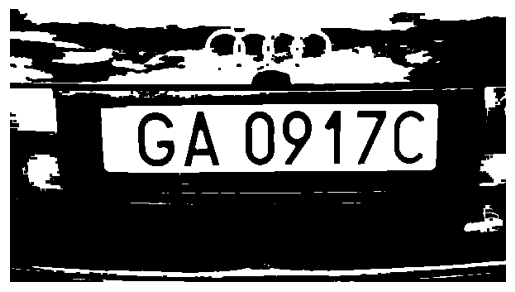

In [6]:
squareKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

light = cv2.morphologyEx(image, cv2.MORPH_CLOSE, squareKernel)
light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

show_image(light)

Next, we compute the **gradient in the x-direction** using the Sobel operator to find vertical edges, which are common in license plate characters.

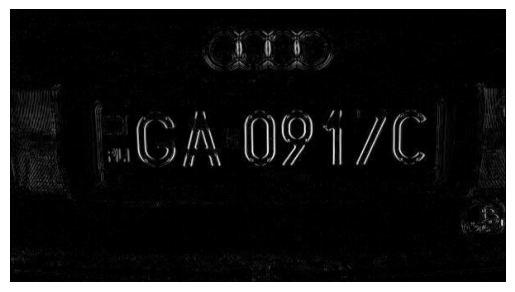

In [7]:
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)

# normalization
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")

show_image(gradX)

We now blur and close the gradient image to help connect components of the license plate, and again apply Otsu's thresholding to binarize the image.

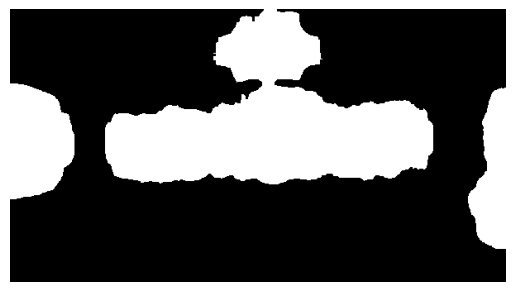

In [8]:
gradX = cv2.GaussianBlur(gradX, (81, 81), 200)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, squareKernel)

thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

show_image(thresh)

We then **bitwise AND** the thresholded image with the light regions to retain only the parts likely to be the license plate. We also perform **erosion and dilation** to clean up small noise.

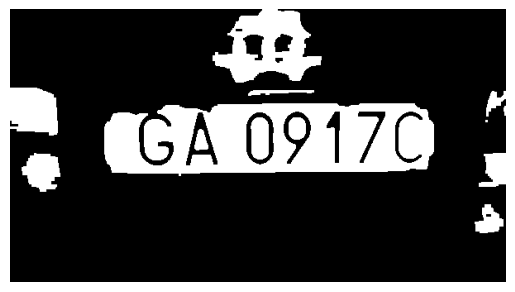

In [9]:
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

thresh = cv2.bitwise_and(thresh, thresh, mask=light)

thresh = cv2.dilate(thresh, None, iterations=2)
thresh = cv2.erode(thresh, None, iterations=1)

show_image(thresh)

Finally, we find contours to detect candidate license plate regions.

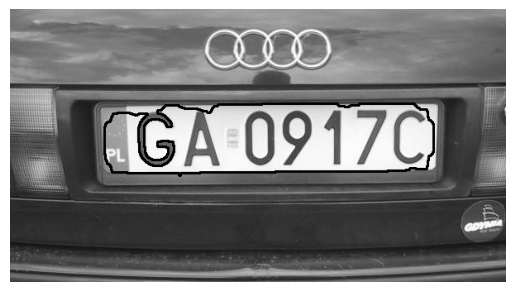

In [10]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:1]

output = image.copy()
cv2.drawContours(output, cnts, -1, (0, 255, 0), 2)
show_image(output)

Candidates:  1
Aspect Ratio:  4.534090909090909


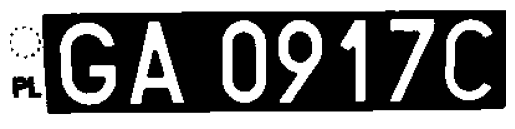

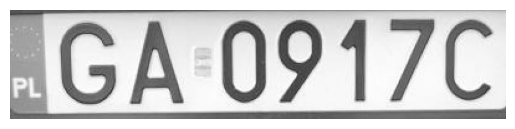

In [11]:
roi, licensePlateContours =  visual.locate_license_plate(image, cnts, minAR=4, maxAR=5)

show_image(roi)

(x, y, w, h) = cv2.boundingRect(licensePlateContours)
licensePlate = image[y:y + h, x:x + w]
show_image(licensePlate)

#### 1.1.2 Problems / Observations

This approach however is not very robust, and it may not work well in all cases. For example, if the license plate is not clearly visible or if there are other objects in the image that are similar to the license plate, this approach may fail.

Candidates:  1
Aspect Ratio:  4.7740112994350286


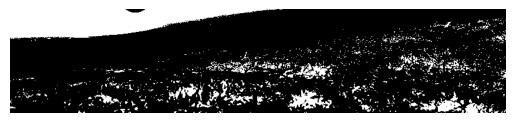

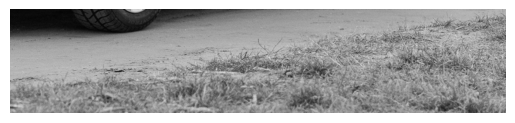

In [12]:
harder_image = cv2.imread("images/hard_car.jpg")

harder_image = cv2.cvtColor(harder_image, cv2.COLOR_BGR2GRAY)

cnts = visual.find_plate(harder_image)

roi, licensePlateContours =  visual.locate_license_plate(harder_image, cnts, minAR=4, maxAR=5)

show_image(roi)

(x, y, w, h) = cv2.boundingRect(licensePlateContours)
inv_licensePlate = harder_image[y:y + h, x:x + w]
show_image(inv_licensePlate)

#### 1.1 Hog + SVM

#### 1.1.1 Concept
HOG (<a href="https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients">Histogram of Oriented Gradients</a>) is a feature descriptor that captures the gradient and edge orientations within localized regions of an image.

<center><img src="images/hog.png" width="400"/></center>
<center><a href="https://medium.com/analytics-vidhya/a-gentle-introduction-into-the-histogram-of-oriented-gradients-fdee9ed8f2aa">Histogram Of Gradients</a></center>

The goal is to divide the image into small bins or windows and evaluate each window to determine whether it contains a license plate. This approach allows us to localize the license plate by asking a binary question (plate present or not) for each bin, followed by classification using SVM.

<center><img src="images/hog_bins.png" width="400"/></center>
<center><a href="https://medium.com/analytics-vidhya/a-gentle-introduction-into-the-histogram-of-oriented-gradients-fdee9ed8f2aa">Example of bin separation combined with HoG</a></center>

<center><img src="images/captcha.png" width="400"/></center>
<center><a href="https://www.google.com/url?sa=i&url=https%3A%2F%2Fwongm.com%2F2024%2F07%2Ffamiliar-looking-traffic-lights-on-google-recaptcha%2F&psig=AOvVaw3uNANR4c6XpGwh1KjysV2M&ust=1744123007492000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCPCQ592SxowDFQAAAAAdAAAAABAE">Exapmle how to create labels with captcha</a></center>

#### 1.1.2 Problems / Observations

This sliding window approach using HOG + SVM is weak because it requires evaluating a large number of candidate windows, which can be slow in real-time applications. It struggles with variations in plate size, orientation, and lighting, often resulting in missed detections or an excessive number of false positives.

#### 2. Deep Learning-Based Methods
Deep learning approaches provide robust detection capabilities in complex and dynamic environments, though they typically require more data and computational power.

- YOLO (You Only Look Once)
  - Leverage the YOLO framework for real-time object detection.
  - Fine-tune the model on license plate datasets to improve localization and accuracy, even under challenging conditions such as occlusions and varying lighting.

- ResNet
  - Utilize deep residual networks (ResNet) to perform feature extraction and classification.
  - Adapt ResNet architectures to the detection task, benefiting from their strong representation learning capabilities for more challenging images.

#### 2.1 YOLO

#### 2.1.1 Concept
YOLO (<a href="https://docs.ultralytics.com/">You Only Look Once</a>) is a deep learning-based object detection framework that processes the entire image in a single forward pass. It divides the image into a grid and predicts bounding boxes along with class probabilities for each grid cell, enabling the detection of multiple objects simultaneously.

Here is example of detection
![YOLO](images/yolo.png)  

Using YOLO for license plate detection means that the model learns to directly identify and localize license plates from full images, without needing to manually slide windows over the image. This end-to-end approach is highly efficient and robust, handling variations in size, orientation, and lighting conditions with greater accuracy than traditional methods.

![YOLO Detection Example](images/yolo_bins.png)  

Example usage of YOLO


image 1/1 c:\Users\pijay\Documents\ALPR\images\captcha.png: 640x448 6 cars, 2 traffic lights, 128.5ms
Speed: 2.0ms preprocess, 128.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


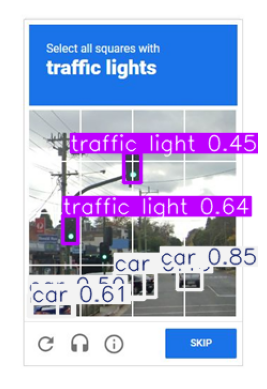

In [ ]:

model = YOLO("yolov8n.pt")
results = model("images/captcha.png")
show_image(results[0].plot())

How to train your own data?

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="license_plate.yaml",  
    epochs=50,                  
    imgsz=640,                  
    batch=16,                   
    name="lp_detector"          
)


Now load out checkpoint and let's run it (used from <a href="https://github.com/Muhammad-Zeerak-Khan/Automatic-License-Plate-Recognition-using-YOLOv8">Repository</a>, worth checking)!


image 1/1 c:\Users\pijay\Documents\ALPR\images\car.png: 480x640 1 license_plate, 70.0ms
Speed: 3.0ms preprocess, 70.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


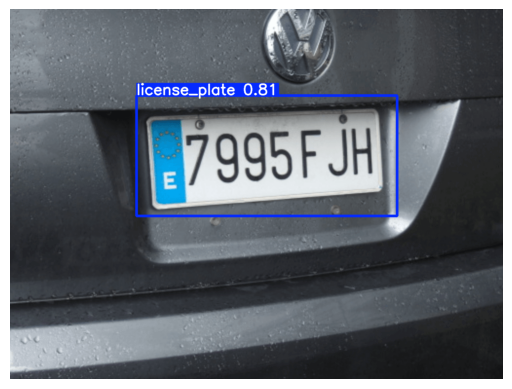

In [ ]:
model = YOLO("lp_detector/license_plate_detector.pt")
results = model("images/car.png")
show_image(results[0].plot())

#### 2.1 CNN

#### 2.1.1 Concept
Convolutional Neural Networks (CNNs) are a class of deep learning models especially well-suited for image-related tasks. In the context of license plate detection, a CNN-based detector processes the input image by dividing it into a grid and classifying each region as either containing a license plate or not. The model learns visual patterns through convolutional layers and makes predictions for each grid cell, allowing it to recognize the presence of a license plate without explicitly scanning the image with sliding windows.

![CNN Architecture](images/cnn_architecture.png)

What size of grind should we use? How to determine it? Of course we could do it manually, but how abou multi-scale preditions?It works, by predicting at different scales simultaneously.

![CNN Architecture](images/multi_scale.png)

### 3. OCR (Optical Character Recognition)

#### 3.1 **CRNN (Convolutional Recurrent Neural Network)**: A deep learning model that combines convolutional layers for feature extraction and recurrent layers for sequence prediction. This approach is more robust and can handle variations in font, size, and orientation of the characters.

We created a CRNN model using pytorch. We used a dataset avaliable here: https://www.kaggle.com/datasets/abdelhamidzakaria/european-license-plates-dataset?resource=download

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = crnn.CRNN(nh=256).to(device)
model.load_state_dict(torch.load("crnn_model.pth"))

<center><img src="images/jupyter/crnn.ppm" width="400"/></center>
<center><a href="https://www.researchgate.net/figure/Architecture-of-the-CRNN-text-recognizer_fig3_360984341">CRNN architecture</a></center>

1. **Convolutional Layers (CNN)**:
   The model contains several convolutional layers that extract features from the input image. These layers are responsible for detecting patterns and structures in the image. 

2. **Recurrent Layers (RNN/LSTM)**:
   The output of the convolutional layers is fed into a recurrent layer. In case of ALPR, we use **LSTM** (Long Short-Term Memory) for recognizing sequences of characters in the license plate.

   A lot of papers use a **Bidirectional LSTM** (BLSTM) architecture, which processes the input sequence in both forward and backward directions. However during our expermients, we found that a unidirectional LSTMs provided way worse results than an unidirectional LSTM.

3. **Fully Connected Layer**:
   The output of the recurrent layer is passed through a fully connected layer, which maps the features to the final output classes. In our case, this would be the characters in the license plate.



##### Character mapping

As a classical CNN classification model, the CRNN model outputs a probability distribution over the characters for each time step. The output is a sequence of probabilities, where each probability corresponds to a character in the license plate.

We map the characters to their corresponding indices using a dictionary. Additionaly we add a **blank** character to the mapping. The blank character is used in the CTC loss function to allow the model to output variable-length sequences.


##### CTC Loss

**CTC Loss** allows the model to align the predicted sequence with the true label, even when the text length varies.
It enables the model to predict **variable-length sequences** and skip over irrelevant parts of the image using a "blank" token.

How CTC works:
1. The model predicts a sequence of characters, including the blank token.
2. All possible alignments of the predicted sequence with the true label are generated.
3. The CTC loss function computes the probability of the true label given the predicted sequence, considering all possible alignments.

##### Our implementation

Our implementation consisted of:
- **Data Preprocessing**: We resized the images to a fixed size and normalized the pixel values, we also applied classical data augmentation the CLAHE histogram equalization, and a 
- 5 Convolutional layers, with RelU activation, Max Pooling and Batch Normalization.
- LSTM layer with 256 units. (unidirectional)
- Linear Layer

Using this architecture and the dataset provided above, we achieved a test accuracy of 75%. It is not very high, but the main issue was mismatched characters that where easily mixed up. For example, the model would predict a "0" instead of an "O", or a "1" instead of an "I".

Lets try applying the model to the license plate we extracted before.

In [29]:
model = crnn.CRNN(nh=256).to(device)

model.load_state_dict(torch.load("crnn_model.pth"))

<All keys matched successfully>

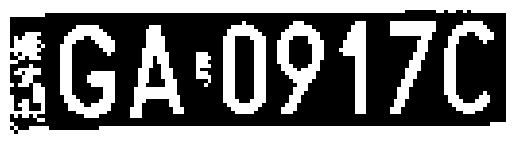

['097']


In [39]:
model.eval()
resized = cv2.resize(licensePlate, (128, 32))

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
resized = clahe.apply(resized)

resized = cv2.adaptiveThreshold(resized, 255,
                        cv2.ADAPTIVE_THRESH_MEAN_C,
                        cv2.THRESH_BINARY_INV, 15, 10)

show_image(resized)

result = model(torch.from_numpy(resized).unsqueeze(0).unsqueeze(0).float().to(device))
print(utils.decode_output(result))

We see that our model is poorly generalized, and it cannot predict the result from an image outside the dataset.
What about an image from the testing set?

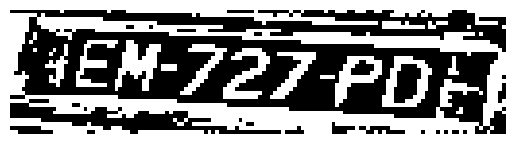

['EM727PD']


In [38]:
model.eval()

test_image = cv2.imread("images/EM727PD.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

resized = cv2.resize(test_image, (128, 32))

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
resized = clahe.apply(resized)

resized = cv2.adaptiveThreshold(resized, 255,
                        cv2.ADAPTIVE_THRESH_MEAN_C,
                        cv2.THRESH_BINARY_INV, 15, 10)

show_image(resized)

result = model(torch.from_numpy(resized).unsqueeze(0).unsqueeze(0).float().to(device))
print(utils.decode_output(result))

#### 3.2 Tesseract OCR

Tesseract is an open-source OCR engine, created by Google.

<center><img src="images\jupyter\tesseract_model.png" width="400"/></center>
<center><a href=https://www.researchgate.net/figure/Tesseract-OCR-Architecture-3_fig1_326016983>Tesseract Model architecture</a></center>



In order to use it, we need to install if first: https://tesseract-ocr.github.io/tessdoc/Installation.html

In [13]:
import pytesseract

gray = cv2.cvtColor(licensePlate, cv2.COLOR_BGR2RGB)

text = pytesseract.image_to_string(gray, config='--psm 7')

print(text)

"GA0917C



Lets see the accuracy of the Tesseract model on our dataset:

In [21]:
path = 'OCR/CRNN/dataset_final/test'
images = glob.glob(os.path.join(path, '*.jpg')) + glob.glob(os.path.join(path, '*.png'))

labels = [os.path.basename(image).split('.')[0] for image in images]
labels = [label.split('_')[0] if '_' in label else label for label in labels]

correct = 0

for i, image in enumerate(images):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    result = pytesseract.image_to_string(image, config='--psm 7')
    if i % 20 == 0:
        print(f"Predicted: {result}, Actual: {labels[i]}")
    correct += int(result == labels[i])

accuracy = correct / len(images)
print(f"Accuracy: {accuracy * 100:.2f}%")

Predicted: , Actual: 2348XR25
Predicted: é Se PR OA 1. |
, Actual: SPR911
Predicted: (BL - 33635]
, Actual: BL33635
Predicted: LYF-277:
, Actual: LYF277
Accuracy: 0.00%


As we can see Tesseract **without fine-tuning** achieves zero accuracy on our dataset. This proves that the dataset is not an easy one.

More on tesseract:
https://static.googleusercontent.com/media/research.google.com/pl//pubs/archive/33418.pdf

### 4. Challenges in License Plate Detection

Let's talk about difficulties while learning how to detect license plates and let's intruduce some solutions!

#### 4.1. Image Quality Issues

- Different angles
- Dirty cars
- Weather conditions eg. fog
- Varing camera distances
- Low resolution

<center><img src="images/dirty_plate.png" width="400"/><img src="images/car_in_fog.png" width="400"/></center>
<center><a href="https://platerecognizer.com/alpr-for-vehicles-without-license-plates/">Difficult images</a></center>

<center><img src="images/DR_YOLO.png" width="600"/><img src="images/feature_extraction.png" width="400"/></center>
<center><a href="https://www.sciencedirect.com/science/article/abs/pii/S0031320324005077">Great models</a></center>

#### 4.2. Environmental Interference

- Presence of billboards and other text-heavy signs
- Multiple vehicles in one frame
- Crowded backgrounds and urban environments

<center><img src="images/multiple_vehicles.png" width="400"/><img src="images/billboard.png" width="400"/></center>
<center><a href="https://platerecognizer.com/alpr-for-vehicles-without-license-plates/">Difficult images 2</a></center>

### 5. Practical Examples and Case Studies

#### 5.1 License Plate Detection in Traffic Monitoring

##### 5.1.1 Problem

<a href="https://medium.com/@API4AI/the-role-of-ai-in-improving-vehicle-recognition-for-parking-management-eed9212719c2">Efficient traffic monitoring and management</a> is crucial due to rising vehicle numbers. A common challenge is the accurate detection and recognition of vehicle license plates.

<center><img src="images/AI_traffic_management.png" width="400"/></center>
<center><a href="https://medium.com/@API4AI/the-role-of-ai-in-improving-vehicle-recognition-for-parking-management-eed9212719c2">AI cause we talk about AI</a></center>

##### 5.1.2 Examples

How could we use it? For example:

- Speed Enforcement - Automatically capturing license plates of speeding vehicles.
- Access Control - Managing entry and exit of vehicles in parking lots, gated communities, and restricted zones.
- Crime Prevention - Tracking stolen vehicles or vehicles involved in criminal activities.
- Traffic Analysis - Collecting data on traffic flow, vehicle count, and identifying congestion points. In this way we could create better infrastructure in the future!

##### 5.1.3 Solutions

- Utilizing convolutional neural networks (CNN) such as YOLO, SSD, or Faster R-CNN.
- Applying image enhancement methods like feature extraction to handle diverse environmental conditions like low visibility, varying lighting, and motion blur. Great example is <a href="https://www.sciencedirect.com/science/article/abs/pii/S0031320324005077">DR-YOLO</a>, which allows to detect object in fog.
- Designing flexible systems capable of integration with existing traffic infrastructure and databases for automatic tracking, logging, and alerting functionalities.

#### 5.2 Detecting Incorrectly Parked Vehicles

##### 5.2.1 Problem

<a href="https://medium.com/@API4AI/the-role-of-ai-in-improving-vehicle-recognition-for-parking-management-eed9212719c2">Incorrectly parked vehicles</a> often lead to traffic congestion, safety hazards, and inefficient utilization of parking spaces.

<center><img src="images/wrong_parking_1.png" width="400"/></center>
<center><a href="https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.shutterstock.com%2Fsearch%2Fbadly-parked-cars&psig=AOvVaw3OQE6ZoFWocmWFSYhVwA7_&ust=1744198579913000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCKCTjZmsyIwDFQAAAAAdAAAAABAb">Please do not park like this</a></center>

##### 5.2.2 Examples

How could we use it? For example:

- Urban Traffic Management - Reducing congestion by promptly identifying and removing illegally parked vehicles.
- Safety Enhancement - Preventing accidents by identifying vehicles obstructing emergency lanes, sidewalks, and crosswalks.
- Parking Space Optimization - Ensuring efficient usage and availability of parking spaces.

##### 5.2.3 Solutions

- Usage of YOLO, Faster R-CNN, or SSD could be beneficial, however also intorduces lack of awarness of environment.
- Implementing spatial analysis algorithms to accurately detect vehicles parked outside designated areas or boundaries.
- GNNs with attention mechanisms to model relationships between parking slots and vehicles. ​
- Utilize ViTs for their capability to capture long-range dependencies in images. 


### 7. Conclusions

It is a well known problem that have many different approaches. Right now we could gain up to 90% accuracy on detection. 

---

## Bibliografia

1. https://medium.com/analytics-vidhya/a-gentle-introduction-into-the-histogram-of-oriented-gradients-fdee9ed8f2aa
1. https://github.com/Muhammad-Zeerak-Khan/Automatic-License-Plate-Recognition-using-YOLOv8
1. https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
1. https://docs.ultralytics.com/
1. https://universe.roboflow.com/project/license-plate-recognition-rxg4e/dataset/11/download
1. https://platerecognizer.com/alpr-for-vehicles-without-license-plates/
1. https://www.sciencedirect.com/science/article/abs/pii/S0031320324005077
1. https://pyimagesearch.com/2020/09/21/opencv-automatic-license-number-plate-recognition-anpr-with-python/
1. https://github.com/tesseract-ocr/tesseract?tab=readme-ov-file
1. https://www.xenonstack.com/insights/crnn-for-text-recognition